# Menganalisis Kertas Kerja COVID-19

Dalam cabaran ini, kita akan meneruskan topik pandemik COVID dan memberi tumpuan kepada pemprosesan kertas kerja saintifik mengenai subjek ini. Terdapat [Dataset CORD-19](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) dengan lebih daripada 7000 (pada masa penulisan) kertas kerja mengenai COVID, yang tersedia bersama metadata dan abstrak (dan untuk kira-kira separuh daripadanya, teks penuh juga disediakan).

Contoh penuh analisis dataset ini menggunakan perkhidmatan kognitif [Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum) diterangkan [dalam catatan blog ini](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/). Kita akan membincangkan versi analisis yang dipermudahkan.


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Mendapatkan Data

Pertama, kita perlu mendapatkan metadata untuk kertas CORD yang akan kita gunakan.

**NOTA**: Kami tidak menyediakan salinan dataset sebagai sebahagian daripada repositori ini. Anda mungkin perlu memuat turun fail [`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) daripada [dataset ini di Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). Pendaftaran dengan Kaggle mungkin diperlukan. Anda juga boleh memuat turun dataset tanpa pendaftaran [di sini](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html), tetapi ia akan merangkumi semua teks penuh selain daripada fail metadata.

Kami akan cuba mendapatkan data secara langsung daripada sumber dalam talian, namun, jika ia gagal, anda perlu memuat turun data seperti yang diterangkan di atas. Juga, adalah wajar untuk memuat turun data jika anda merancang untuk bereksperimen dengannya lebih lanjut, untuk menjimatkan masa menunggu.

> **NOTA** bahawa dataset ini agak besar, sekitar 1 Gb saiznya, dan baris kod berikut mungkin mengambil masa yang lama untuk diselesaikan! (~5 minit)


In [146]:
df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')
# df = pd.read_csv("metadata.csv")
df.head()

C:\winapp\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning:

Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.



cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

Kami kini akan menukar lajur tarikh penerbitan kepada `datetime`, dan plot histogram untuk melihat julat tarikh penerbitan.


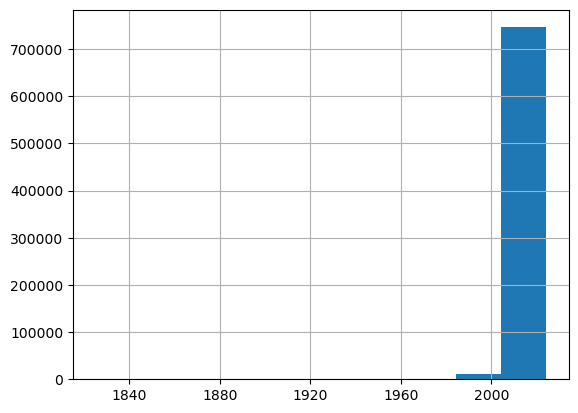

In [147]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_time'].hist()
plt.show()

## Ekstraksi Data Berstruktur

Mari kita lihat jenis maklumat yang boleh kita ekstrak dengan mudah daripada abstrak. Salah satu perkara yang mungkin menarik perhatian kita ialah melihat strategi rawatan yang wujud, dan bagaimana ia berkembang dari masa ke masa. Sebagai permulaan, kita boleh menyusun secara manual senarai ubat-ubatan yang mungkin digunakan untuk merawat COVID, serta senarai diagnosis. Kemudian, kita menyemak dan mencari istilah yang sepadan dalam abstrak kertas kajian.


In [148]:
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin', 
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]

for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))
    
for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


Kami telah menambah beberapa lajur ke dalam dataframe kami yang mengandungi bilangan kali sesuatu ubat/diagnosis muncul dalam abstrak.

> **Nota** bahawa kami menambah ruang di awal perkataan semasa mencari substring. Jika tidak, kami mungkin mendapat hasil yang salah, kerana *chloroquine* juga akan ditemui di dalam substring *hydroxychloroquine*. Selain itu, kami memaksa penukaran lajur abstrak kepada `str` untuk mengelakkan ralat - cuba keluarkan `str` dan lihat apa yang berlaku.

Untuk memudahkan kerja dengan data, kita boleh mengekstrak sub-bingkai yang hanya mengandungi kiraan ubat, dan mengira jumlah bilangan kejadian. Ini memberikan kita ubat yang paling popular:


In [149]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

Name  Count
0   hydroxychloroquine   9806
3           remdesivir   7861
2          tocilizumab   6118
1          chloroquine   4578
8              heparin   4161
5            lopinavir   3811
4         azithromycin   3585
7        dexamethasone   3340
9          favipiravir   2439
10  methylprednisolone   1600
6            ritonavir    948

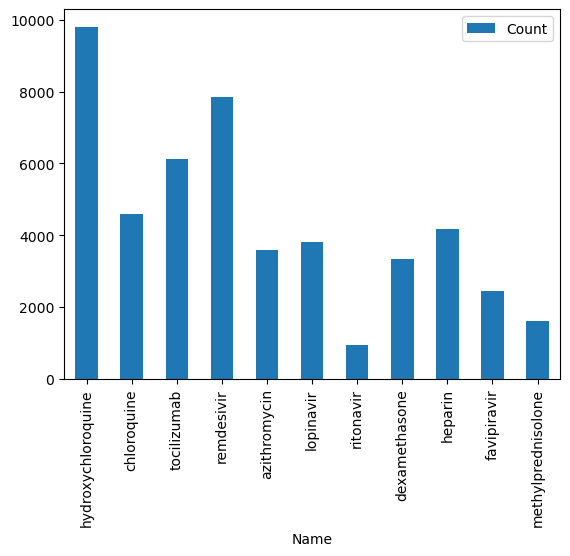

In [150]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## Mencari Corak dalam Strategi Rawatan

Dalam contoh di atas, kita telah melakukan `sum` untuk semua nilai, tetapi kita juga boleh melakukan perkara yang sama secara bulanan:


In [151]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2020-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

hydroxychloroquine  chloroquine  tocilizumab  \
publish_time publish_time                                                 
2020         1                           3672         1773         1779   
             2                              0           19            0   
             3                             45           72            5   
             4                            188          238           50   
             5                            459          191          158   
             6                            381          149          243   
             7                            381          178          202   
             8                            307          115          172   
             9                            319          123          185   
             10                           319           96          212   
             11                           272           66          170   
             12                           255          102          229   
2021         1                           2191          780         1787   
             2                            163           66          184   
             3                            172           85          190   
             4                            198           70          125   
             5                            141           55          138   
             6                            144           29          138   
             7                            112           49           96   

                           remdesivir  azithromycin  lopinavir  ritonavir  \
publish_time publish_time                                                   
2020         1                   2134          1173       1430        370   
             2                      3             3         18         11   
             3                     27            12         52         16   
             4                    124            68        113         13   
             5                    209           132        135         41   
             6                    186           110        132         18   
             7                    165           108        138         29   
             8                    165           145         91         24   
             9                    190            91         98         28   
             10                   227            72        127         39   
             11                   197            79        104         27   
             12                   271            98         76         31   
2021         1                   2523           892        841        198   
             2                    173            85         76          9   
             3                    295            87        100         17   
             4                    161            83         60         13   
             5                    179            69         55         21   
             6                    182            75         41         12   
             7                    270            64         59          5   

                           dexamethasone  heparin  favipiravir  \
publish_time publish_time                                        
2020         1                       561      984          666   
             2                         1        3           12   
             3                         3       21           11   
             4                        14       77           48   
             5                        12       92           48   
             6                        48       84           30   
             7                        58      117           56   
             8                        56       95           45   
             9                        90      111           46   
             10                       97      117           81   
             11                       77 

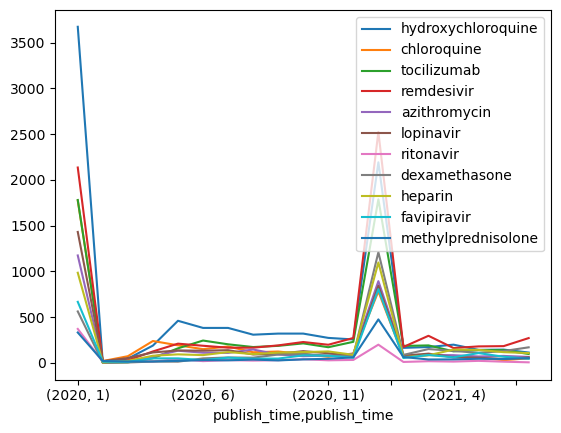

In [152]:
dfmt.plot()
plt.show()

Satu pemerhatian menarik ialah kita mempunyai lonjakan besar di dua lokasi: Januari 2020 dan Januari 2021. Ini disebabkan oleh fakta bahawa beberapa kertas kerja tidak mempunyai tarikh penerbitan yang dinyatakan dengan jelas, dan ia dinyatakan sebagai Januari tahun berkenaan.

Untuk memahami data dengan lebih baik, mari kita visualisasikan hanya beberapa ubat. Kita juga akan "padamkan" data untuk Januari, dan gantikannya dengan beberapa nilai sederhana, supaya plot kelihatan lebih kemas:


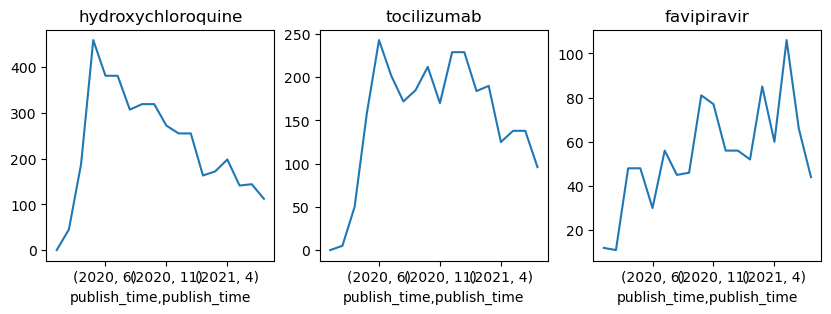

In [153]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(10,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

Perhatikan bagaimana populariti hidroksiklorokuin meningkat dalam beberapa bulan pertama, dan kemudian mula menurun, manakala bilangan sebutan favipiravir menunjukkan peningkatan yang stabil. Satu lagi cara yang baik untuk menggambarkan populariti relatif adalah dengan menggunakan **graf timbunan** (atau **graf kawasan** dalam istilah Pandas):


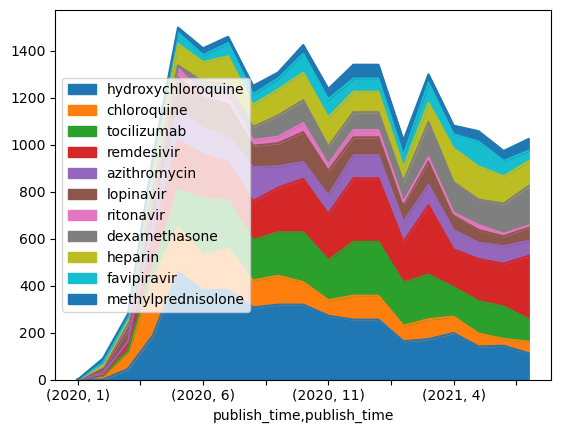

In [154]:
dfmt.plot.area()
plt.show()

Lebih jauh lagi, kita boleh mengira populariti relatif dalam peratus:


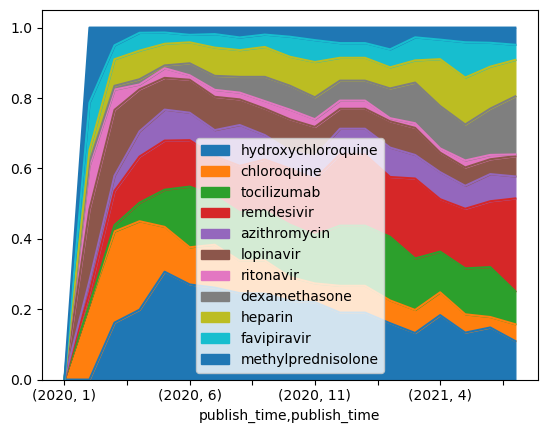

In [155]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()

## Mengira Hubungan Perubatan-Diagnosis

Salah satu hubungan yang paling menarik untuk kita kaji adalah bagaimana diagnosis yang berbeza dirawat dengan ubat-ubatan yang berbeza. Untuk memvisualisasikannya, kita perlu mengira **peta kekerapan kejadian bersama**, yang akan menunjukkan berapa kali dua istilah disebut dalam kertas yang sama.

Peta seperti ini pada dasarnya adalah matriks 2D, yang paling baik diwakili oleh **numpy array**. Kita akan mengira peta ini dengan menelusuri semua abstrak, dan menandakan entiti yang muncul di sana:


In [156]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [157]:
m

array([[4788., 2264.,  741., 2109.,  348., 2730.,  975.],
       [2111., 1238.,  231.,  998.,   79., 1394.,  364.],
       [2186.,  821.,  691., 1063.,  185., 1136.,  573.],
       [3210., 2191.,  522., 1538.,  160., 2191.,  622.],
       [1803.,  773.,  406.,  880.,  133.,  909.,  410.],
       [1982., 1102.,  379.,  885.,  113., 1366.,  370.],
       [ 504.,  356.,   83.,  259.,   23.,  354.,  106.],
       [1419.,  640.,  345.,  742.,  108.,  760.,  314.],
       [1537.,  678.,  330.,  782.,   93.,  826.,  301.],
       [ 967.,  634.,  201.,  431.,   44.,  656.,  136.],
       [ 660.,  336.,  293.,  385.,   53.,  452.,  148.]])

Salah satu cara untuk memvisualisasikan matriks ini adalah dengan melukis **peta haba**:


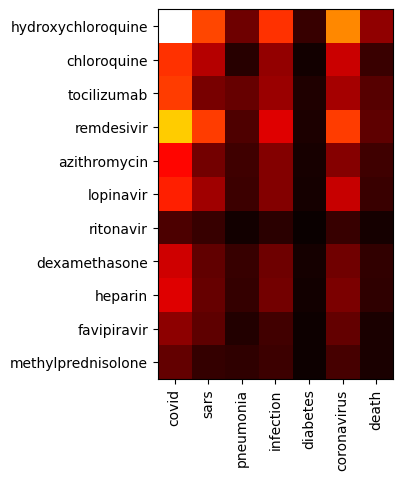

In [158]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

Namun, visualisasi yang lebih baik boleh dilakukan menggunakan diagram **Sankey**! `matplotlib` tidak mempunyai sokongan terbina untuk jenis diagram ini, jadi kita perlu menggunakan [Plotly](https://plotly.com/python/) seperti yang diterangkan [dalam tutorial ini](https://plotly.com/python/sankey-diagram/).

Untuk membuat diagram sankey menggunakan plotly, kita perlu membina senarai berikut:
* Senarai `all_nodes` yang mengandungi semua nod dalam graf, termasuk kedua-dua ubat-ubatan dan diagnosis
* Senarai indeks sumber dan sasaran - senarai ini akan menunjukkan nod mana yang bergerak ke kiri, dan mana yang ke bahagian kanan diagram
* Senarai semua pautan, setiap pautan terdiri daripada:
   - Indeks sumber dalam array `all_nodes`
   - Indeks sasaran
   - Nilai yang menunjukkan kekuatan pautan. Ini adalah nilai tepat dari matriks ko-berlaku kita.
   - Warna pautan secara opsyenal. Kita akan menyediakan pilihan untuk menyerlahkan beberapa istilah bagi kejelasan.

Kod generik untuk melukis diagram sankey disusun sebagai fungsi `sankey` yang berasingan, yang mengambil dua senarai (kategori sumber dan sasaran) dan matriks ko-berlaku. Ia juga membolehkan kita menentukan ambang, dan mengabaikan semua pautan yang lebih lemah daripada ambang tersebut - ini menjadikan diagram kurang kompleks.


In [160]:
import plotly.graph_objects as go

def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])

## Kesimpulan

Anda telah melihat bahawa kita boleh menggunakan kaedah yang agak mudah untuk mengekstrak maklumat daripada sumber data yang tidak berstruktur, seperti teks. Dalam contoh ini, kita telah menggunakan senarai ubat-ubatan yang sedia ada, tetapi ia akan menjadi lebih berkuasa jika menggunakan teknik pemprosesan bahasa semula jadi (NLP) untuk melakukan pengekstrakan entiti daripada teks. Dalam [blog post ini](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/), kami menerangkan cara menggunakan perkhidmatan awan untuk pengekstrakan entiti. Pilihan lain adalah dengan menggunakan perpustakaan NLP Python seperti [NLTK](https://www.nltk.org/) - pendekatan untuk mengekstrak maklumat daripada teks menggunakan NLTK diterangkan [di sini](https://www.nltk.org/book/ch07.html).


## Cabaran

Teruskan penyelidikan data kertas COVID mengikut garis panduan berikut:

1. Bina matriks kebergantungan bersama untuk pelbagai ubat, dan lihat ubat mana yang sering muncul bersama (iaitu disebut dalam satu abstrak). Anda boleh mengubah kod untuk membina matriks kebergantungan bersama bagi ubat dan diagnosis.
1. Visualisasikan matriks ini menggunakan peta haba.
1. Sebagai matlamat tambahan, anda mungkin ingin memvisualisasikan kebergantungan bersama ubat menggunakan [chord diagram](https://en.wikipedia.org/wiki/Chord_diagram). [Perpustakaan ini](https://pypi.org/project/chord/) mungkin dapat membantu anda melukis chord diagram.
1. Sebagai matlamat tambahan lain, cuba ekstrak dos pelbagai ubat (seperti **400mg** dalam *ambil 400mg chloroquine setiap hari*) menggunakan ekspresi biasa, dan bina dataframe yang menunjukkan dos berbeza untuk ubat berbeza. **Nota**: pertimbangkan nilai berangka yang berada dalam jarak teks yang dekat dengan nama ubat.



---

**Penafian**:  
Dokumen ini telah diterjemahkan menggunakan perkhidmatan terjemahan AI [Co-op Translator](https://github.com/Azure/co-op-translator). Walaupun kami berusaha untuk memastikan ketepatan, sila ambil perhatian bahawa terjemahan automatik mungkin mengandungi kesilapan atau ketidaktepatan. Dokumen asal dalam bahasa asalnya harus dianggap sebagai sumber yang berwibawa. Untuk maklumat penting, terjemahan manusia profesional adalah disyorkan. Kami tidak bertanggungjawab atas sebarang salah faham atau salah tafsir yang timbul daripada penggunaan terjemahan ini.
